<a href="https://colab.research.google.com/github/lior0110/main/blob/master/stockRNNClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os 
if not os.path.exists('main'): os.system('git clone https://github.com/lior0110/main/')
os.chdir('main')

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [0]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [0]:
class stock_rnn:
  def __init__(self, file1, file2, merge_column = 'Date'):
    self.stock1 = pd.read_csv(file1, parse_dates=True)
    self.stock2 = pd.read_csv(file2, parse_dates=True)
    # see if 'Adj Close' is the same as 'Close'
    # if yes drop 'Adj Close'
    if 'Adj Close' in self.stock1.columns:
      test = self.stock1['Adj Close'] == self.stock1['Close']
      if all(self.stock1['Adj Close'] == self.stock1['Close']):
          self.stock1 = self.stock1.drop(columns='Adj Close')
    
    if 'Adj Close' in self.stock2.columns:
      test = self.stock2['Adj Close'] == self.stock2['Close']
      if all(self.stock2['Adj Close'] == self.stock2['Close']):
          self.stock2 = self.stock2.drop(columns='Adj Close')
    # merge the two datas
    # self.joined_data = self.stock1.join(self.stock2.set_index('Date'), on='Date', lsuffix='_stock1', rsuffix='_stock2')
    self.merged_data = self.stock1.merge(self.stock2, on=merge_column, suffixes=('_stock1', '_stock2'))
    # self.merged_data = self.stock1.merge(self.stock2, on=['Date', 'Open'], suffixes=('_stock1', '_stock2'))

  # make data and target arrays
  def make_input_output(self, target_style = 'two candles', window_len = 100, useVolume = True, useJoined = True, 
                        look_forward = 1, Multi_Step_model = False):
    self.target_style = target_style # what is the target style we want  # / 'one candle' / 'two candles' / 'UD'
    self.window_len = window_len # what is the input window length
    self.useVolume = useVolume # use Volume for the calculation
    self.useJoined = useJoined # use both datas for the calculation
    self.look_forward = int(look_forward) # time stemps to look forward in the target
    self.Multi_Step_model = Multi_Step_model

    if self.useJoined:
      self.data = self.merged_data
    else:
      if target_style == 'two candles':
        self.target_style = 'one candle'
      self.data = self.stock1
    
    # output initialization
    self.initialize_output()

    # input initialization
    self.initialize_input()

    # calculate inputs and outputs
    if self.Multi_Step_model:
      print('not done yet')
    else:
      self.calculate_single_outputs()

    for i in range(self.data.shape[0]-self.window_len-self.look_forward+1):
      if useVolume:
        self.X[i,:,:] = self.data.iloc[i:i+self.window_len,1:].values
      else:
        if useJoined:
          self.X[i,:,:4] = self.data.iloc[i:i+self.window_len,1:5].values
          self.X[i,:,4:] = self.data.iloc[i:i+self.window_len,6:10].values
        else:
          self.X[i,:,:] = self.data.iloc[i:i+self.window_len,1:-1].values

  def initialize_output(self):
    # output initialization
    if self.target_style == 'one candle':
      if self.Multi_Step_model and self.look_forward > 1:
        self.y = np.zeros((self.data.shape[0]-self.window_len-self.look_forward+1,self.look_forward,4))
      else:
        self.y = np.zeros((self.data.shape[0]-self.window_len-self.look_forward+1,4))
    elif self.target_style == 'UD':
      if self.Multi_Step_model and self.look_forward > 1:
        # self.y = np.zeros((self.data.shape[0]-self.window_len-self.look_forward+1,self.look_forward,1))
        self.y = np.zeros((self.data.shape[0]-self.window_len-self.look_forward+1,self.look_forward,2))
      else:
        # self.y = np.zeros((self.data.shape[0]-self.window_len-self.look_forward+1,1))
        self.y = np.zeros((self.data.shape[0]-self.window_len-self.look_forward+1,2))
    else:
      if self.Multi_Step_model and self.look_forward > 1:
        self.y = np.zeros((self.data.shape[0]-self.window_len-self.look_forward+1,self.look_forward,8))
      else:
        self.y = np.zeros((self.data.shape[0]-self.window_len-self.look_forward+1,8))

  def initialize_input(self):
    # input initialization
    if self.useJoined:
      if self.useVolume:
        self.X = np.zeros((self.data.shape[0]-self.window_len-self.look_forward+1,self.window_len,self.data.shape[1]-1))
      else:
        self.X = np.zeros((self.data.shape[0]-self.window_len-self.look_forward+1,self.window_len,self.data.shape[1]-3))
    else:
      if self.useVolume:
        self.X = np.zeros((self.data.shape[0]-self.window_len-self.look_forward+1,self.window_len,self.data.shape[1]-1))
      else:
        self.X = np.zeros((self.data.shape[0]-self.window_len-self.look_forward+1,self.window_len,self.data.shape[1]-2))

  def calculate_single_outputs(self):
    for i in range(self.data.shape[0]-self.window_len-self.look_forward+1):
      if self.target_style == 'UD':
        # target of Up/Down for next day
        if (self.stock1['Close'][i+self.window_len+self.look_forward-1] - self.stock1['Close'][i+self.window_len-1]) > 0:
          # self.y[i] = 1
          self.y[i][0] = 1
        elif (self.stock1['Close'][i+self.window_len+self.look_forward-1] - self.stock1['Close'][i+self.window_len-1]) < 0:
          # self.y[i] = -1
          self.y[i][1] = 1
      elif self.target_style == 'one candle':
        # predict next candle
        # self.y[i] = self.data.iloc[i+self.window_len,1:5]
        if self.useJoined:
          self.y[i][0] = self.data.Open_stock1[i+self.window_len] # next Open
          self.y[i][1] = self.data.High_stock1[i+self.window_len:i+self.window_len+self.look_forward].max() # next High
          self.y[i][2] = self.data.Low_stock1[i+self.window_len:i+self.window_len+self.look_forward].min() # next Low
          self.y[i][3] = self.data.Close_stock1[i+self.window_len+self.look_forward-1] # next Close
        else:
          self.y[i][0] = self.data.Open[i+self.window_len] # next Open
          self.y[i][1] = self.data.High[i+self.window_len:i+self.window_len+self.look_forward].max() # next High
          self.y[i][2] = self.data.Low[i+self.window_len:i+self.window_len+self.look_forward].min() # next Low
          self.y[i][3] = self.data.Close[i+self.window_len+self.look_forward-1] # next Close
      else:
        # predict next candle in both datas
        # self.y[i][:4] = self.data.iloc[i+self.window_len,1:5]
        # self.y[i][4:] = self.data.iloc[i+self.window_len,6:10]
        # for stock1
        self.y[i][0] = self.data.Open_stock1[i+self.window_len] # next Open
        self.y[i][1] = self.data.High_stock1[i+self.window_len:i+self.window_len+self.look_forward].max() # next High
        self.y[i][2] = self.data.Low_stock1[i+self.window_len:i+self.window_len+self.look_forward].min() # next Low
        self.y[i][3] = self.data.Close_stock1[i+self.window_len+self.look_forward-1] # next Close
        # for stock2
        self.y[i][4] = self.data.Open_stock2[i+self.window_len] # next Open
        self.y[i][5] = self.data.High_stock2[i+self.window_len:i+self.window_len+self.look_forward].max() # next High
        self.y[i][6] = self.data.Low_stock2[i+self.window_len:i+self.window_len+self.look_forward].min() # next Low
        self.y[i][7] = self.data.Close_stock2[i+self.window_len+self.look_forward-1] # next Close
            
  def calculate_multi_outputs(self):
    for i in range(self.data.shape[0]-self.window_len-self.look_forward+1):
      if self.target_style == 'UD':
        # target of Up/Down for next day
        if (self.stock1['Close'][i+self.window_len+self.look_forward-1] - self.stock1['Close'][i+self.window_len-1]) > 0:
          # self.y[i] = 1
          self.y[i][0] = 1
        elif (self.stock1['Close'][i+self.window_len+self.look_forward-1] - self.stock1['Close'][i+self.window_len-1]) < 0:
          # self.y[i] = -1
          self.y[i][1] = 1
      elif self.target_style == 'one candle':
        # predict next candle
        # self.y[i] = self.data.iloc[i+self.window_len,1:5]
        if self.useJoined:
          self.y[i][0] = self.data.Open_stock1[i+self.window_len] # next Open
          self.y[i][1] = self.data.High_stock1[i+self.window_len:i+self.window_len+self.look_forward].max() # next High
          self.y[i][2] = self.data.Low_stock1[i+self.window_len:i+self.window_len+self.look_forward].min() # next Low
          self.y[i][3] = self.data.Close_stock1[i+self.window_len+self.look_forward-1] # next Close
        else:
          self.y[i][0] = self.data.Open[i+self.window_len] # next Open
          self.y[i][1] = self.data.High[i+self.window_len:i+self.window_len+self.look_forward].max() # next High
          self.y[i][2] = self.data.Low[i+self.window_len:i+self.window_len+self.look_forward].min() # next Low
          self.y[i][3] = self.data.Close[i+self.window_len+self.look_forward-1] # next Close
      else:
        # predict next candle in both datas
        # self.y[i][:4] = self.data.iloc[i+self.window_len,1:5]
        # self.y[i][4:] = self.data.iloc[i+self.window_len,6:10]
        # for stock1
        self.y[i][0] = self.data.Open_stock1[i+self.window_len] # next Open
        self.y[i][1] = self.data.High_stock1[i+self.window_len:i+self.window_len+self.look_forward].max() # next High
        self.y[i][2] = self.data.Low_stock1[i+self.window_len:i+self.window_len+self.look_forward].min() # next Low
        self.y[i][3] = self.data.Close_stock1[i+self.window_len+self.look_forward-1] # next Close
        # for stock2
        self.y[i][4] = self.data.Open_stock2[i+self.window_len] # next Open
        self.y[i][5] = self.data.High_stock2[i+self.window_len:i+self.window_len+self.look_forward].max() # next High
        self.y[i][6] = self.data.Low_stock2[i+self.window_len:i+self.window_len+self.look_forward].min() # next Low
        self.y[i][7] = self.data.Close_stock2[i+self.window_len+self.look_forward-1] # next Close
            

  def make_train_test(self, data_distribution = (0.7, 0.15, 0.15), start_on = 0):
    self.data_distribution = np.array(data_distribution) # data distribution
    if all(self.data_distribution < 1):
      self.data_distribution = np.floor(self.data_distribution * self.X.shape[0])
    # initialization
    # self.y_train = np.zeros((self.data_distribution[0], self.y.shape[1]))
    # self.y_valid = np.zeros((self.data_distribution[1], self.y.shape[1]))
    # self.y_test = np.zeros((self.data_distribution[2], self.y.shape[1]))
    
    # self.X_train = np.zeros((self.data_distribution[0], self.X.shape[1], self.X.shape[2]))
    # self.X_valid = np.zeros((self.data_distribution[0], self.X.shape[1], self.X.shape[2]))
    # self.X_test = np.zeros((self.data_distribution[0], self.X.shape[1], self.X.shape[2]))
    
    # train test split
    point1 = start_on
    point2 = int(start_on + self.data_distribution[0])
    point3 = int(start_on + self.data_distribution[0:2].sum())
    point4 = int(start_on + self.data_distribution.sum())
    self.y_train = self.y[point1:point2,:].copy()
    self.y_valid = self.y[point2:point3,:].copy()
    self.y_test = self.y[point3:point4,:].copy()
    self.X_train = self.X[point1:point2,:,:].copy()
    self.X_valid = self.X[point2:point3,:,:].copy()
    self.X_test = self.X[point3:point4,:,:].copy()

    # get the max and min in the train data
    self.get_max_min()

    # data scaling
    self.X_train = self.data_scale(self.X_train)
    self.X_valid = self.data_scale(self.X_valid)
    self.X_test = self.data_scale(self.X_test)

    # target scaling
    self.target_scale()

  def get_max_min(self):
    # get the max and min in the train data
    if self.useJoined:
      if self.useVolume:
        self.maxPrice = np.max(self.X_train[:,:,:4])
        # print('max Price: ',self.maxPrice)
        self.minPrice = np.min(self.X_train[:,:,:4])
        # print('min Price: ',self.minPrice)
        self.maxPrice2 = np.max(self.X_train[:,:,5:-1])
        # print('max Price2: ',self.maxPrice2)
        self.minPrice2 = np.min(self.X_train[:,:,5:-1])
        # print('min Price2: ',self.minPrice2)
        self.maxVolume = np.max(self.X_train[:,:,4])
        # print('max Volume: ',self.maxVolume)
        self.minVolume = np.min(self.X_train[:,:,4])
        # print('min Volume: ',self.minVolume)
        self.maxVolume2 = np.max(self.X_train[:,:,-1])
        # print('max Volume2: ',self.maxVolume2)
        self.minVolume2 = np.min(self.X_train[:,:,-1])
        # print('min Volume2: ',self.minVolume2)
      else:
        self.maxPrice = np.max(self.X_train[:,:,:4])
        # print('max Price: ',self.maxPrice)
        self.minPrice = np.min(self.X_train[:,:,:4])
        # print('min Price: ',self.minPrice)
        self.maxPrice2 = np.max(self.X_train[:,:,4:])
        # print('max Price2: ',self.maxPrice2)
        self.minPrice2 = np.min(self.X_train[:,:,4:])
        # print('min Price2: ',self.minPrice2)
    else:
      self.maxPrice = np.max(self.X_train[:,:,:-1])
      # print('max Price: ',self.maxPrice)
      self.minPrice = np.min(self.X_train[:,:,:-1])
      # print('min Price: ',self.minPrice)
      if self.useVolume:
        self.maxVolume = np.max(self.X_train[:,:,-1])
        # print('max Volume: ',self.maxVolume)
        self.minVolume = np.min(self.X_train[:,:,-1])
        # print('min Volume: ',self.minVolume)

  def data_scale(self, data):
    # data scaling
    scaled_data = data
    if self.useJoined:
      if self.useVolume:
        scaled_data[:,:,:4] = (data[:,:,:4] - self.minPrice) / (self.maxPrice - self.minPrice)
        scaled_data[:,:,4] = (data[:,:,4] - self.minVolume) / (self.maxVolume - self.minVolume)
        scaled_data[:,:,5:-1] = (data[:,:,5:-1] - self.minPrice2) / (self.maxPrice - self.minPrice2)
        scaled_data[:,:,-1] = (data[:,:,-1] - self.minVolume2) / (self.maxVolume2 - self.minVolume2)
      else:
        scaled_data[:,:,:4] = (data[:,:,:4] - self.minPrice) / (self.maxPrice - self.minPrice)
        scaled_data[:,:,4:] = (data[:,:,4:] - self.minPrice2) / (self.maxPrice - self.minPrice2)
    else:
      if self.useVolume:
        scaled_data[:,:,:-1] = (data[:,:,:-1] - self.minPrice) / (self.maxPrice - self.minPrice)
        scaled_data[:,:,-1] = (data[:,:,-1] - self.minVolume) / (self.maxVolume - self.minVolume)
      else:
        scaled_data[:,:,:] = (data[:,:,:] - self.minPrice) / (self.maxPrice - self.minPrice)
    
    return scaled_data

  def data_descale(self, data):
    # data descaling
    descaled_data = data
    if self.useJoined:
      if self.useVolume:
        descaled_data[:,:,:4] = data[:,:,:4] * (self.maxPrice - self.minPrice) + self.minPrice
        descaled_data[:,:,4] = data[:,:,4] * (self.maxVolume - self.minVolume) + self.minVolume
        descaled_data[:,:,5:-1] = data[:,:,5:-1] * (self.maxPrice - self.minPrice2) + self.minPrice2
        descaled_data[:,:,-1] = data[:,:,-1] * (self.maxVolume2 - self.minVolume2) + self.minVolume2
      else:
        descaled_data[:,:,:4] = data[:,:,:4] * (self.maxPrice - self.minPrice) + self.minPrice
        descaled_data[:,:,4:] = data[:,:,4:] * (self.maxPrice - self.minPrice2) + self.minPrice2
    else:
      if self.useVolume:
        descaled_data[:,:,:-1] = data[:,:,:-1] * (self.maxPrice - self.minPrice) + self.minPrice
        descaled_data[:,:,-1] = data[:,:,-1] * (self.maxVolume - self.minVolume) + self.minVolume
      else:
        descaled_data[:,:,:] = data[:,:,:] * (self.maxPrice - self.minPrice) + self.minPrice
    
    return descaled_data

  def target_scale(self):
    # target scaling
    if self.target_style == 'one candle':
      self.y_train = (self.y_train - self.minPrice) / (self.maxPrice - self.minPrice)
      # plt.plot(self.y_train)
      # plt.show()
      self.y_valid = (self.y_valid - self.minPrice) / (self.maxPrice - self.minPrice)
      # plt.plot(self.y_valid)
      # plt.show()
      self.y_test = (self.y_test - self.minPrice) / (self.maxPrice - self.minPrice)
      # plt.plot(self.y_test)
      # plt.show()
    if self.target_style == 'two candles':
      # x=1
      self.y_train[:,:4] = (self.y_train[:,:4] - self.minPrice) / (self.maxPrice - self.minPrice)
      self.y_train[:,4:] = (self.y_train[:,4:] - self.minPrice2) / (self.maxPrice2 - self.minPrice2)
      # plt.plot(self.y_train)
      # plt.show()
      self.y_valid[:,:4] = (self.y_valid[:,:4] - self.minPrice) / (self.maxPrice - self.minPrice)
      self.y_valid[:,4:] = (self.y_valid[:,4:] - self.minPrice2) / (self.maxPrice2 - self.minPrice2)
      # plt.plot(self.y_valid)
      # plt.show()
      self.y_test[:,:4] = (self.y_test[:,:4] - self.minPrice) / (self.maxPrice - self.minPrice)
      self.y_test[:,4:] = (self.y_test[:,4:] - self.minPrice2) / (self.maxPrice2 - self.minPrice2)
      # plt.plot(self.y_test)
      # plt.show()

  def target_descale(self, data):
    # target descaling
    descaled_target = data
    if self.target_style == 'one candle':
      descaled_target = data * (self.maxPrice - self.minPrice) + self.minPrice
    if self.target_style == 'two candles':
      descaled_target[:,:4] = data[:,:4] * (self.maxPrice - self.minPrice) + self.minPrice
      descaled_target[:,4:] = data[:,4:] * (self.maxPrice2 - self.minPrice2) + self.minPrice2
    return descaled_target

  def getModel(self, architecture = 'GRU'):
    if architecture == 'LSTM':
      # The LSTM architecture
      regressorLSTM = tf.keras.Sequential()
      # First LSTM layer with Dropout regularisation
      regressorLSTM.add(layers.LSTM(units=50, return_sequences=True, input_shape=(self.X_train.shape[1],self.X_train.shape[2])))
      regressorLSTM.add(layers.Dropout(0.2))
      # Second LSTM layer
      regressorLSTM.add(layers.LSTM(units=50, return_sequences=True))
      regressorLSTM.add(layers.Dropout(0.2))
      # Third LSTM layer
      regressorLSTM.add(layers.LSTM(units=50, return_sequences=True))
      regressorLSTM.add(layers.Dropout(0.2))
      # Fourth LSTM layer 
      regressorLSTM.add(layers.LSTM(units=50))
      regressorLSTM.add(layers.Dropout(0.2))
      # The output layer
      if self.target_style == 'UD':
        regressorLSTM.add(layers.Dense(units=self.y_train.shape[1], activation='softmax'))
      else:
        regressorLSTM.add(layers.Dense(units=self.y_train.shape[1]))

      self.Model = regressorLSTM
    else: # architecture == 'GRU'
      # The GRU architecture
      regressorGRU = tf.keras.Sequential()
      # First GRU layer with Dropout regularisation
      regressorGRU.add(layers.GRU(units=50, return_sequences=True, input_shape=(self.X_train.shape[1],self.X_train.shape[2])))
      regressorGRU.add(layers.Dropout(0.2))
      # Second GRU layer
      regressorGRU.add(layers.GRU(units=50, return_sequences=True, input_shape=(self.X_train.shape[1],self.X_train.shape[2])))
      regressorGRU.add(layers.Dropout(0.2))
      # Third GRU layer
      regressorGRU.add(layers.GRU(units=50, return_sequences=True, input_shape=(self.X_train.shape[1],self.X_train.shape[2])))
      regressorGRU.add(layers.Dropout(0.2))
      # Fourth GRU layer
      regressorGRU.add(layers.GRU(units=50))
      regressorGRU.add(layers.Dropout(0.2))
      # The output layer
      if self.target_style == 'UD':
        regressorGRU.add(layers.Dense(units=self.y_train.shape[1], activation='softmax'))
      else:
        regressorGRU.add(layers.Dense(units=self.y_train.shape[1]))

      self.Model = regressorGRU

  def one_time_training(self, architecture = 'GRU'):
    self.getModel(architecture = architecture)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    if self.target_style == 'UD':
      self.Model.compile(optimizer='RMSProp', loss='CategoricalCrossentropy', metrics=['accuracy', 'CategoricalCrossentropy', 'CategoricalHinge']) # optimizer='Adam'/'RMSProp' 
    else:
      self.Model.compile(optimizer='RMSProp', loss='mse', metrics=['mse']) # optimizer='Adam'/'RMSProp' 
    print(self.Model.summary())
    self.hist = self.Model.fit(self.X_train, self.y_train, epochs = 100, callbacks=[callback], validation_data=(self.X_valid, self.y_valid)) # , batch_size=32
    results = self.Model.evaluate(self.X_test, self.y_test)
    print(results)
    self.test_test(descale = False)

  def incremental_training(self, data_distribution = (0.7, 0.15, 0.15), start_on = 0, architecture = 'GRU'):    
    self.data_distribution = np.array(data_distribution) # data distribution
    if all(self.data_distribution < 1):
      self.data_distribution = np.floor(self.data_distribution * self.X.shape[0])
    
    start_point = start_on
    self.make_train_test(data_distribution = self.data_distribution, start_on = start_point)

    self.getModel(architecture = architecture)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    if self.target_style == 'UD':
      self.Model.compile(optimizer='RMSProp', loss='CategoricalCrossentropy', metrics=['accuracy', 'CategoricalCrossentropy', 'CategoricalHinge']) # optimizer='Adam'/'RMSProp' 
    else:
      self.Model.compile(optimizer='RMSProp', loss='mse', metrics=['mse']) # optimizer='Adam'/'RMSProp' 
    print(self.Model.summary())
    while (start_point + self.data_distribution[0:2].sum()) < self.X.shape[0]:
      print('starting on: ', start_point)
      self.make_train_test(data_distribution = self.data_distribution, start_on = start_point)
      self.hist = self.Model.fit(self.X_train, self.y_train, epochs = 100, callbacks=[callback], validation_data=(self.X_valid, self.y_valid)) # , batch_size=32
      results = self.Model.evaluate(self.X_test, self.y_test)
      print(results)
      self.test_test(descale = False)

      start_point += self.data_distribution[2]

  def test_test(self, descale = True):
    predicted_stock_price = T.Model.predict(self.X_test)
    if descale:
      predicted_stock_price = self.target_descale(predicted_stock_price)
    
    # Visualising the test results
    if descale:
      plt.plot(self.target_descale(self.y_test), color = 'pink', label = 'Real Stock Price')
    else:
      plt.plot(self.y_test, color = 'pink', label = 'Real Stock Price')
    plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
    plt.title('Stock Price Prediction on test data')
    plt.xlabel('Time')
    plt.ylabel('Stock Price on test data')
    # plt.legend()
    plt.show()

    return predicted_stock_price

  def predict_last_point(self):
    # predict for lest point
    if self.useJoined:
      if self.useVolume:
        lest_data = self.data.iloc[-self.window_len:,1:].values
      else:
        lest_data[:,:4] = self.data.iloc[-self.window_len:,1:5].values
        lest_data[:,6:10] = self.data.iloc[-self.window_len:,6:10].values
    else:
      if self.useVolume:
        lest_data = self.data.iloc[-self.window_len:].values
      else:
        lest_data = self.data.iloc[-self.window_len:,:-1].values
    lest_data = lest_data.reshape((1,self.window_len,self.X_train.shape[2]))
    lest_data = self.data_scale(lest_data)

    predicted_stock_price = self.Model.predict(lest_data)
    predicted_stock_price = self.target_descale(predicted_stock_price)
    # target_style = 'two candles' # / 'one candle' / 'two candles'
    if self.target_style == 'one candle':
      print("predicted stock price for next step is:")
      print("Open, {}".format(predicted_stock_price[:,0]))
      print("High, {}".format(predicted_stock_price[:,1]))
      print("Low, {}".format(predicted_stock_price[:,2]))
      print("Close, {}".format(predicted_stock_price[:,3]))
    elif self.target_style == 'two candles':
      print("predicted first stock price for next step is:")
      print("Open, {}".format(predicted_stock_price[:,0]))
      print("High, {}".format(predicted_stock_price[:,1]))
      print("Low, {}".format(predicted_stock_price[:,2]))
      print("Close, {}".format(predicted_stock_price[:,3]))
      print("predicted second stock price for next step is:")
      print("Open, {}".format(predicted_stock_price[:,4]))
      print("High, {}".format(predicted_stock_price[:,5]))
      print("Low, {}".format(predicted_stock_price[:,6]))
      print("Close, {}".format(predicted_stock_price[:,7]))
    elif self.target_style == 'UD':
      print('The probability for UP candle: {}'.format(predicted_stock_price[:,0]))
      print('The probability for DOWN candle: {}'.format(predicted_stock_price[:,1]))





In [0]:
T.predict_last_point()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_56 (GRU)                 (None, 100, 50)           9300      
_________________________________________________________________
dropout_56 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
gru_57 (GRU)                 (None, 100, 50)           15300     
_________________________________________________________________
dropout_57 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
gru_58 (GRU)                 (None, 100, 50)           15300     
_________________________________________________________________
dropout_58 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
gru_59 (GRU)                 (None, 50)              

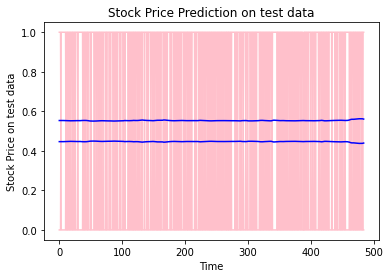

The probability for UP candle: [0.5581676]
The probability for DOWN candle: [0.44183248]


In [63]:
T = stock_rnn('DJI.csv','GSPC.csv') # ,merge_column='DateTime'
T.make_input_output(target_style='UD') # 
T.make_train_test()
T.one_time_training()
T.predict_last_point()
# T.incremental_training(data_distribution = (1000,200,200))
# T.Model.evaluate

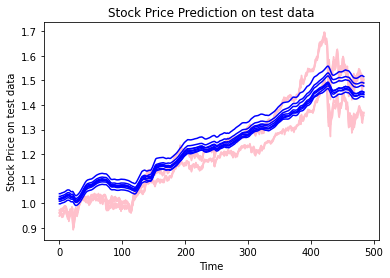

In [0]:
# T.make_input_output()
# T.make_train_test(data_distribution = (500,100,100), start_on=1000)
# T.y_train.shape
# T.X_train[0,0,:]
predicted_stock_price = T.Model.predict(T.X_valid)

# Visualising the test results
plt.plot(T.y_valid, color = 'pink', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction on test data')
plt.xlabel('Time')
plt.ylabel('Stock Price on test data')
# plt.legend()
plt.show()

# plt.plot(T.y_train)

In [0]:
data_distribution = np.array([0.7, 0.15, 0.15])
# if a < 1:
data_distribution *= 10 
data_distribution.round() #np.floor(data_distribution)
data_distribution.sum()

10.0

In [0]:
T.y_train.shape

(400, 8)